In [1]:
import gzip
import json
import pickle
import scipy.sparse

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from scipy import spatial
from tqdm.auto import tqdm
from lightfm import LightFM
from lightfm.evaluation import precision_at_k

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-683te7vj because the default path (/home/i313924/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.
Matplotlib is building the font cache; this may take a moment.


In [2]:
THREADS = 8

In [4]:
model = pd.read_pickle('/pio/scratch/1/i313924/data/lightfm_data/warp_model_300_epochs_slim.pkl')
dataset = pd.read_pickle('/pio/scratch/1/i313924/data/lightfm_data/slim_dataset.pkl')

## ABX (only popular)

In [8]:
abx_tests = pd.read_json('/pio/scratch/1/i313924/data/test_data/test_ABX_weighted_slim.json', lines=True)

In [9]:
def get_item_embedding(model, dataset, asin):
    item_id = dataset.mapping()[2][asin]
    return model.item_embeddings[item_id]

In [9]:
A = np.zeros((10000, 100))
B = np.zeros((10000, 100))
X = np.zeros((10000, 100))

for i, test in tqdm(abx_tests.iterrows()):
    A[i, :] = get_item_embedding(model, dataset, test["A"])
    B[i, :] = get_item_embedding(model, dataset, test["B"])
    X[i, :] = get_item_embedding(model, dataset, test["X"])

dist_A = ((A - X)**2).sum(axis=1)
dist_B = ((B - X)**2).sum(axis=1)

0it [00:00, ?it/s]

In [11]:
(dist_A < dist_B).mean()

0.5282

In [12]:
cos_dist_A = np.zeros(10000)
cos_dist_B = np.zeros(10000)

for i in tqdm(range(10000)):
    cos_dist_A[i] = spatial.distance.cosine(A[i, :], X[i, :])
    cos_dist_B[i] = spatial.distance.cosine(B[i, :], X[i, :])

  0%|          | 0/10000 [00:00<?, ?it/s]

In [13]:
(cos_dist_A < cos_dist_B).mean()

0.5795

## Suits & dresses ABX

In [13]:
abx_tests = pd.read_json('/pio/scratch/1/i313924/data/test_data/Suits_Dresses_ABX.json', lines=True)

A = np.zeros((10000, 100))
B = np.zeros((10000, 100))
X = np.zeros((10000, 100))

for i, test in tqdm(abx_tests.iterrows()):
    A[i, :] = get_item_embedding(model, dataset, test["A"])
    B[i, :] = get_item_embedding(model, dataset, test["B"])
    X[i, :] = get_item_embedding(model, dataset, test["X"])

dist_A = ((A - X)**2).sum(axis=1)
dist_B = ((B - X)**2).sum(axis=1)

print((dist_A < dist_B).mean())

cos_dist_A = np.zeros(10000)
cos_dist_B = np.zeros(10000)

for i in tqdm(range(10000)):
    cos_dist_A[i] = spatial.distance.cosine(A[i, :], X[i, :])
    cos_dist_B[i] = spatial.distance.cosine(B[i, :], X[i, :])

print((cos_dist_A < cos_dist_B).mean())

0it [00:00, ?it/s]

0.5091


  0%|          | 0/10000 [00:00<?, ?it/s]

0.5287


## Embeddings PCA

In [14]:
item_embeddings = pd.DataFrame(model.item_embeddings)
user_embeddings = pd.DataFrame(model.user_embeddings)

In [15]:
embeddings = pd.concat([item_embeddings, user_embeddings], keys=['items', 'users'])

In [17]:
pca = PCA(n_components=2)
pca.fit(embeddings)

PCA(n_components=2)

In [18]:
reduced_item_embeddings = pd.DataFrame(pca.transform(embeddings.loc["items"]))
reduced_user_embeddings = pd.DataFrame(pca.transform(embeddings.loc["users"]))

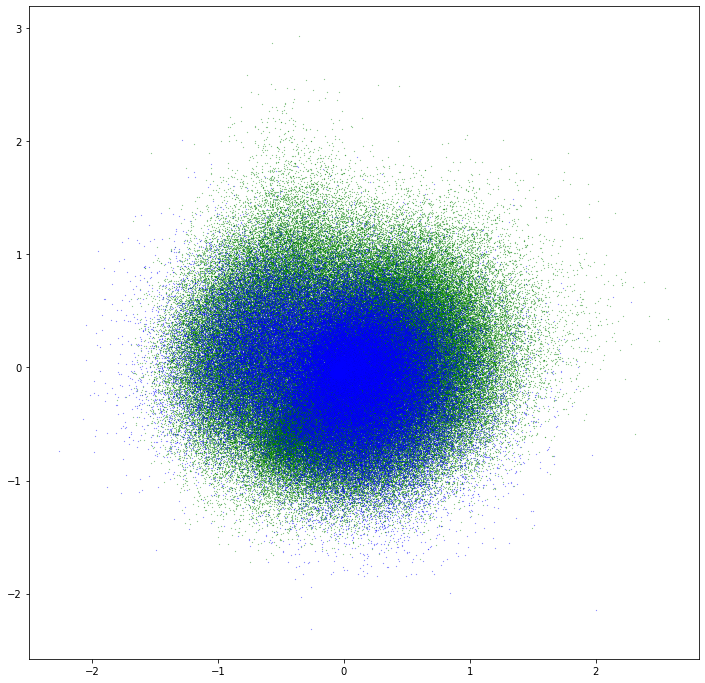

In [19]:
plt.figure(figsize=(12, 12))
plt.scatter(reduced_item_embeddings[0], reduced_item_embeddings[1], c='green', s=0.03)
plt.scatter(reduced_user_embeddings[0], reduced_user_embeddings[1], c='blue', s=0.03)

In [21]:
item_mapping = {v: k for k, v in dataset.mapping()[2].items()}
user_mapping = {v: k for k, v in dataset.mapping()[0].items()}

In [22]:
reduced_item_embeddings = reduced_item_embeddings.rename(index=item_mapping)

In [23]:
categories = pd.read_json('/pio/scratch/1/recommender_systems/interim/Amazon/meta_Clothing_Shoes_and_Jewelry_categories.json', lines=True)

In [24]:
reduced_item_embeddings = reduced_item_embeddings.join(categories.set_index('asin'))

In [25]:
reduced_item_embeddings.columns = ['0', '1', 'category_1', 'category_2']

<AxesSubplot:xlabel='0', ylabel='1'>

/pio/scratch/1/i313924/miniconda3/envs/venv/lib/python3.6/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


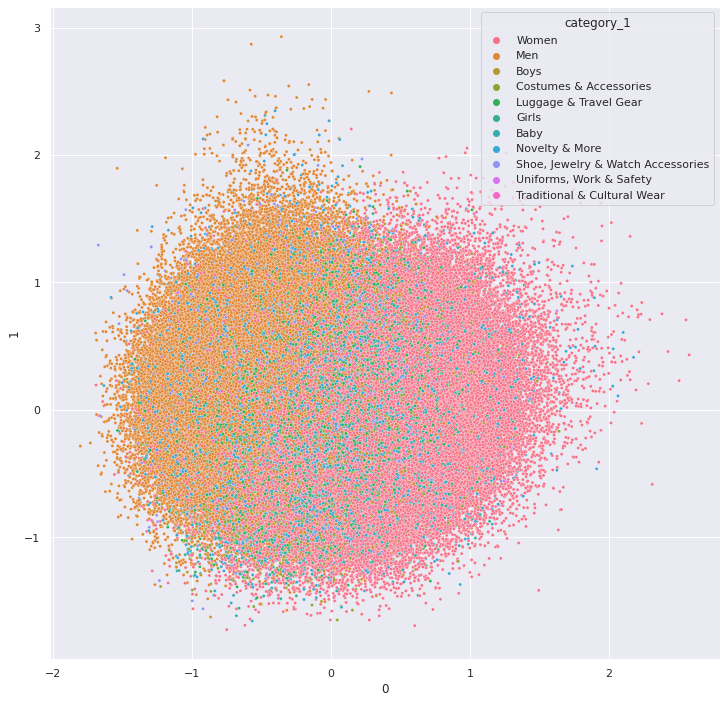

In [26]:
sns.set(rc={'figure.figsize':(12,12)})
sns.scatterplot(x='0', y='1', data=reduced_item_embeddings, hue='category_1', s=10)

<AxesSubplot:xlabel='0', ylabel='1'>

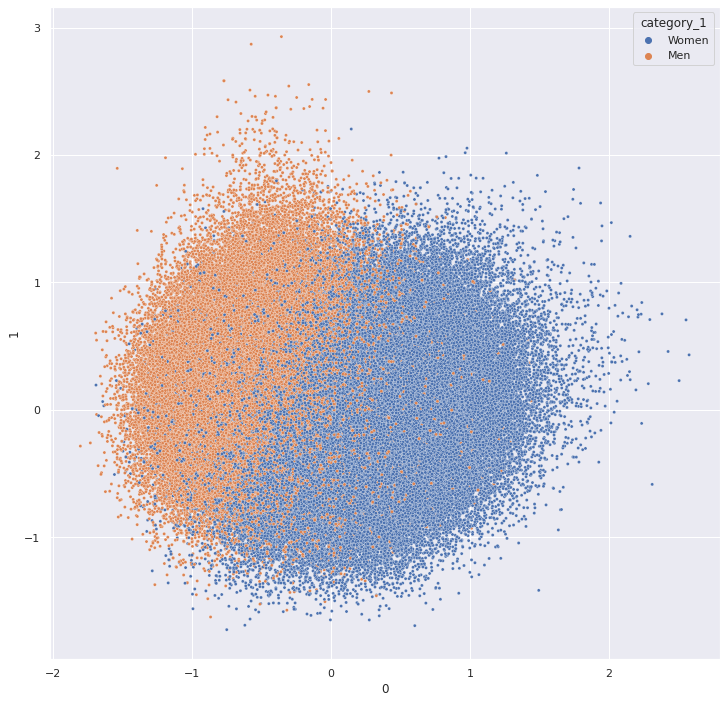

In [27]:
sns.scatterplot(x='0', y='1', data=reduced_item_embeddings[reduced_item_embeddings['category_1'].isin(['Women', 'Men'])], hue='category_1', s=10)